<a href="https://colab.research.google.com/github/mohanaditya910/eip-season4-batch1/blob/master/week2/mnist_submission_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!mkdir drive/'My Drive'/models/mnist-data_augmentation

mkdir: cannot create directory ‘drive/My Drive/models/mnist-data_augmentation’: File exists


In [3]:
import numpy as np
from keras.utils import np_utils
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
#########data augmentation cell#####################


datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.05,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.05,
    shear_range=0.2,  # set range for random shear
    zoom_range=0.05,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=False,  # randomly flip images   ############not advisable because some numbers when flipped can represent other numbers..
    vertical_flip=False,  # randomly flip images     #########################
    # set rescaling factor (applied before any other transformation)
    rescale=None, #already done....
    # set function that will be applied on each input
    preprocessing_function=None,

##############can explore this part......


    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
#    validation_split=0 i will use test data as val_data....
                        )

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

In [0]:
from os.path import join ,exists
import os
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import  Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2
from keras.initializers import glorot_normal
from keras.regularizers import l2

In [0]:
def skeleton_dropout(input_shape,num_classes,n_c_factor_3,n_c_1,layers_in_block,dropout):

  model=Sequential()
  for i in range(layers_in_block):
    if i==0:
      model.add(Conv2D(((i+1)*n_c_factor_3),kernel_size=3,input_shape=(28,28,1),activation='relu',use_bias=False,kernel_initializer=glorot_normal(seed=None)))#26
      model.add(BatchNormalization())
    else:
      model.add(Conv2D(((i+1)*n_c_factor_3),kernel_size=3,activation='relu',use_bias=False,kernel_initializer=glorot_normal(seed=None)))#24,22
      model.add(BatchNormalization())
    
  model.add(Dropout(dropout))

  model.add(MaxPooling2D(pool_size=(2,2)))#11
  model.add(Conv2D(filters=n_c_1,kernel_size=1,activation='relu',use_bias=False,kernel_initializer=glorot_normal(seed=None)))#11
  model.add(BatchNormalization())

  for i in range(layers_in_block):
    model.add(Conv2D(((i+1)*n_c_factor_3),kernel_size=3,activation='relu',use_bias=False,kernel_initializer=glorot_normal(seed=None)))#9,7,5
    model.add(BatchNormalization())

  model.add(Dropout(dropout))

  #no maxpooling
  model.add(Conv2D(filters=num_classes,kernel_size=1,activation='relu',use_bias=False,kernel_initializer=glorot_normal(seed=None)))#5
  #activation is avoided.
  model.add(Conv2D(filters=num_classes,kernel_size=3,activation='relu',use_bias=False,kernel_initializer=glorot_normal(seed=None))) #3   #provide activation
  model.add(Conv2D(filters=num_classes,kernel_size=3,use_bias=False,kernel_initializer=glorot_normal(seed=None)))
  ##

  model.add(Flatten())
  model.add(Activation('softmax'))

  return model

In [0]:
from keras.optimizers import SGD,Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.001 * 1/(1 + 0.319 * epoch), 10)

mkdir: cannot create directory ‘drive/My Drive/models/mnist-LRS’: File exists
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 7)         63        
_________________________________________________________________
batch_normalization_8 (Batch (None, 26, 26, 7)         28        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 14)        882       
_________________________________________________________________
batch_normalization_9 (Batch (None, 24, 24, 14)        56        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 22, 22, 21)        2646      
_________________________________________________________________
batch_normalization_10 (Batc (None, 22, 22, 21)        84        
__________________________________________

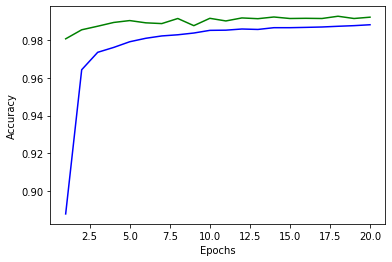

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 8)         72        
_________________________________________________________________
batch_normalization_15 (Batc (None, 26, 26, 8)         32        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 16)        1152      
_________________________________________________________________
batch_normalization_16 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 22, 22, 24)        3456      
_________________________________________________________________
batch_normalization_17 (Batc (None, 22, 22, 24)        96        
_________________________________________________________________
dropout_5 (Dropout)          (None, 22, 22, 24)       

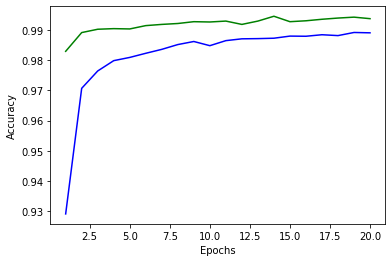

In [14]:
#####################introducing learning rate scheduler......#########################################
!mkdir drive/'My Drive'/models/mnist-LRS
layer_configs=[[7,10],[8,10]]
base_path="/content/drive/My Drive/models/mnist-LRS/"
dropout=0.1
#opt=SGD(lr=0.001,momentum=0.99) ###decay and lr tuning can be done
opt=Adam(lr=0.001)
for layer_config in layer_configs:

  add_path="{}_{}_{}/".format(layer_config[0],layer_config[1],dropout)
  if not exists(join(base_path,add_path)):
    print(not exists(join(base_path,add_path)))
    os.mkdir(join(base_path,add_path))
  #print(filepath_initial)
  filepath_initial=join(base_path,add_path)
  filepath=filepath_initial+"weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
  cp=ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=0,save_best_only=True,save_weights_only=False,mode='max',period=1)

  input_shape=(28,28,1)
  num_classes=10
  n_c_factor_3=layer_config[0]
  n_c_1=layer_config[1]
  layers_in_block=3


  model=skeleton_dropout(input_shape,num_classes,n_c_factor_3,n_c_1,layers_in_block,dropout)
  model.summary()
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  

  history=model.fit_generator(datagen.flow(X_train, Y_train,batch_size=32),
                                validation_data=(X_test, Y_test),
                                callbacks=[cp,LearningRateScheduler(scheduler, verbose=1)],
                                epochs=20)


  acc=history.history['acc']
  val_acc=history.history['val_acc']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs=range(1,len(acc)+1)

  plt.plot(epochs,acc,'b',label='Train_acc')
  plt.plot(epochs,val_acc,'g',label='Val_acc')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.show()